# LDM prediction script

In [1]:
import os
import sys
import time
import math
import h5py
import logging
import warnings
import numpy as np
from glob import glob
from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator

# supress regular warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR) 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# supress tensorflow warnings
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

# adjust for time step embedding layer
tf.config.run_functions_eagerly(True)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import model_utils as mu
import vae_utils as vu

In [4]:
def norm_precip(x):
    return np.log(x+1)

def norm_rh(x):
    return (x-50)/28/2

def norm_t(x):
    return (x-281)/10/2

def norm_u(x):
    return (x-3.5)/6.5/2

def norm_v(x):
    return (x)/6.5/2

def norm_pwat(x):
    return (x-20.5)/15/2

def norm_cape(x):
    return (x-200)/450/2

In [5]:
def reverse_diffuse(model, x_in1, x_in2, total_timesteps, gdf_util):
    L_valid = len(x_in1)
    x_out = np.empty(x_in1.shape)

    for i in range(L_valid):
        x1 = x_in1[i, ...][None, ...]
        x2 = x_in2[i, ...][None, ...]
        
        for t in reversed(range(0, total_timesteps)):
            tt = tf.cast(tf.fill(1, t), dtype=tf.int64)
            pred_noise = model.predict([x1, tt, x2], verbose=0)
            model_mean, _, model_log_variance =  gdf_util.p_mean_variance(pred_noise, x=x1, t=tt, clip_denoised=True)
            nonzero_mask = (1 - (np.array(tt)==0)).reshape((1, 1, 1, 1))
            x1 = np.array(model_mean) + nonzero_mask * np.exp(0.5 * np.array(model_log_variance)) * np.random.normal(size=x1.shape)
        x_out[i, ...] = x1

    return x_out

## Import LDM

In [6]:
total_timesteps = 50 # diffusion time steps
norm_groups = 8 # number of attention heads, number of layer normalization groups 

# min-max values of the diffusion target (learning target) 
clip_min = -1.0
clip_max = 1.0

precip_max = np.log(100+1)

input_shape = (128, 256, 1) # the tensor shape of reverse diffusion input
gfs_shape = (128, 256, 8) # the tensor shape of GFS embeddings

widths = [64, 96, 128, 256] # number of convolution kernels per up-/downsampling level
feature_sizes = [32, 16, 8, 4]

left_attention = [False, False, True, True] # True: use multi-head attnetion on each up-/downsampling level
right_attention = [False, False, True, True]
num_res_blocks = 2  # Number of residual blocks

N_atten1 = np.sum(left_attention)
N_atten2 = np.sum(right_attention)

load_weights = True # True: load previous weights
# location of the previous weights
model_name = '/glade/work/ksha/GAN/models/LDM_025_resize{}-{}_res{}_tune1/'.format(
    N_atten1, N_atten2, num_res_blocks)

lr = 0

In [7]:
def build_model(input_shape, gfs_shape, widths, feature_sizes, left_attention, right_attention, num_res_blocks=2, norm_groups=8,
                interpolation='bilinear', activation_fn=keras.activations.swish,):

    first_conv_channels = widths[0]
    
    image_input = layers.Input(shape=input_shape, name="image_input")
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")
    gfs_input = layers.Input(shape=gfs_shape, name="gfs_input")
    
    x = layers.Conv2D(first_conv_channels, kernel_size=(3, 3), padding="same",
                      kernel_initializer=mu.kernel_init(1.0),)(image_input)

    temb = mu.TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = mu.TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)

    skips = [x]

    # DownBlock
    has_attention = left_attention
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = mu.ResidualBlock(widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb])
            
            if has_attention[i]:
                # GFS cross-attention inputs
                size_ = feature_sizes[i]
                x_gfs = gfs_input
                x_gfs = layers.Resizing(size_, 2*size_, interpolation='bilinear')(x_gfs)

                x_gfs = layers.Conv2D(int(0.5*widths[i]), kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)

                x_gfs = layers.Conv2D(widths[i], kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)
                
                x = layers.MultiHeadAttention(num_heads=norm_groups, key_dim=widths[i])(x, x_gfs)
                
            skips.append(x)

        if widths[i] != widths[-1]:
            x = mu.DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = mu.ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb])
    
    size_ = feature_sizes[-1]
    x_gfs = gfs_input
    x_gfs = layers.Resizing(size_, 2*size_, interpolation='bilinear')(x_gfs)
    
    x_gfs = layers.Conv2D(int(0.5*widths[-1]), kernel_size=(3, 3), padding="same",)(x_gfs)
    x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
    x_gfs = activation_fn(x_gfs)

    x_gfs = layers.Conv2D(widths[-1], kernel_size=(3, 3), padding="same",)(x_gfs)
    x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
    x_gfs = activation_fn(x_gfs)
    
    x = layers.MultiHeadAttention(num_heads=norm_groups, key_dim=widths[-1])(x, x_gfs)
    
    x = mu.ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb])

    # UpBlock
    has_attention = right_attention
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = mu.ResidualBlock(widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb])
            
            if has_attention[i]:
                
                # GFS cross-attention inputs
                size_ = feature_sizes[i]
                x_gfs = gfs_input
                x_gfs = layers.Resizing(size_, 2*size_, interpolation='bilinear')(x_gfs)

                x_gfs = layers.Conv2D(int(0.5*widths[i]), kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)

                x_gfs = layers.Conv2D(widths[i], kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)
                
                x = layers.MultiHeadAttention(num_heads=norm_groups, key_dim=widths[i])(x, x_gfs)
                
        if i != 0:
            x = mu.UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv2D(input_shape[-1], (3, 3), padding="same", kernel_initializer=mu.kernel_init(0.0))(x)
    return keras.Model([image_input, time_input, gfs_input], x, name="unet")


In [8]:
# Reverse diffusino model
model = build_model(input_shape=input_shape, gfs_shape=gfs_shape, widths=widths, 
                    feature_sizes=feature_sizes, left_attention=left_attention, right_attention=right_attention, 
                    num_res_blocks=num_res_blocks, norm_groups=norm_groups, activation_fn=keras.activations.swish)

# Compile the mdoel
model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=lr),)

# load previous weights
W_old = mu.dummy_loader(model_name)
model.set_weights(W_old)

## Data preparation

In [9]:
# configure the forward diffusion steps
gdf_util = mu.GaussianDiffusion(timesteps=total_timesteps)

In [10]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]
    elev_GFS = h5io['elev_GFS'][...]

In [15]:
year = 2023
N_days = 365

ini = 6
lead = 3

day_start = 0
day_end = 1

N_ens = 10
thres_zero_mask = 0
thres_high_precip = norm_precip(10)

In [12]:
gapx = 7
gapy = 12

# data size info
size_x = 128; size_y = 256
x_gfs = 105; y_gfs = 242 # 0.25 deg GFS size

base = datetime(year, 1, 1)
date_list = [base + timedelta(days=d) for d in range(N_days)]

# ------- file locations and names ------ #
name_gfs = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_{}_ini{:02d}_f{:02d}.hdf'
name_apcp = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_APCP_{}_ini{:02d}_f{:02d}.hdf'
name_MRMS = '/glade/campaign/cisl/aiml/ksha/GFS/MRMS_y{}.hdf'

name_save = '/glade/campaign/cisl/aiml/ksha/LDM_025/LDM_day{:03d}_ini{:02d}_lead{:02d}.npy'

## Main prediction loop

In [13]:
T = 20

In [16]:
# ------- Import data ------- #
with h5py.File('/glade/campaign/cisl/aiml/ksha/GFS/MRMS_01H_y{}_025.hdf'.format(year), 'r') as h5io:
    MRMS = h5io['MRMS'][...]
N_total = len(MRMS)

with h5py.File(name_gfs.format(year, ini, lead), 'r') as h5io:
    CAPE = h5io['CAPE'][...]
    PWAT = h5io['PWAT'][...]
    T800 = h5io['T800'][...]
    U800 = h5io['U800'][...]
    V800 = h5io['V800'][...]
    RH800 = h5io['RH800'][...]

with h5py.File(name_apcp.format(year, ini, lead), 'r') as h5io:
    APCP = h5io['APCP'][...]

MRMS_true = np.empty((x_gfs, y_gfs,)); MRMS_true[...] = np.nan
APCP_true = np.empty((x_gfs, y_gfs,)); APCP_true[...] = np.nan

for day in range(day_start, day_end, 1):
    
    # name_ = name_save .format(day, ini, lead)
    # if os.path.isfile(name_) is False:
        
    start_time = time.time()
    print('LDM prediction starts ...')
    N_hours = day*24 + ini + lead
    
    if N_hours < N_total:
        
        # ------- data allocations ------- #
        data = np.empty((1, size_x, size_y, 9))
        data[...] = 0.0
        
        gfs = np.empty((1, x_gfs, y_gfs, 7))
        gfs[...] = np.nan
        
        MRMS_pred = np.empty((N_ens, x_gfs, y_gfs,)); MRMS_pred[...] = np.nan
        # ----- data pre-processing ----- #
        
        MRMS_temp = MRMS[N_hours, ...] + MRMS[N_hours-1, ...] + MRMS[N_hours-2, ...]
        # if MRMS has no NaNs
        if np.sum(np.isnan(MRMS_temp)) == 0:
            
            gfs[..., 0] = APCP[day, ...]
            gfs[..., 1] = CAPE[day, ...]
            gfs[..., 2] = PWAT[day, ...]
            gfs[..., 3] = T800[day, ...]
            gfs[..., 4] = U800[day, ...]
            gfs[..., 5] = V800[day, ...]
            gfs[..., 6] = RH800[day, ...]

            data[:, gapy:x_gfs+gapy, gapx:y_gfs+gapx, 0] = MRMS_temp
            data[:, gapy:x_gfs+gapy, gapx:y_gfs+gapx, 1:8] = gfs
            data[:, gapy:x_gfs+gapy, gapx:y_gfs+gapx, 8] = elev_GFS # normalized elevatino
            
            # data normalization
            data[..., 0] = norm_precip(data[..., 0]) # MRMS
            data[..., 1] = norm_precip(data[..., 1]) # GFS APCCP
            data[..., 2] = norm_cape(data[..., 2]) # GFS CAPE
            data[..., 3] = norm_pwat(data[..., 3]) # PWAT
            data[..., 4] = norm_t(data[..., 4]) # T800
            data[..., 5] = norm_u(data[..., 5]) # U800
            data[..., 6] = norm_v(data[..., 6]) # V800
            data[..., 7] = norm_rh(data[..., 7]) # RH800

            temp = data[..., 1]
            temp[temp<0] = 0
            temp = 2*(temp/precip_max-0.5)
            temp[temp>1.0] = 1.0
            data[..., 1] = temp
                        
            # ---------- LDM prediction ------- #
            # diffusion steps
            data_gfs_in = data[..., 1:]
            
            t_diffuse_ = (T)*np.ones(1)
            t_diffuse = t_diffuse_.astype(int)
            
            # --- ensemble ----- #
            for n in range(N_ens):
                # sample random noise
                noise_ = np.random.normal(size=((1,)+input_shape))
                forward_diffuse = np.array(gdf_util.q_sample(data[..., 1][..., None], t_diffuse, noise_))

                # reverse diffusion
                Y_pred = reverse_diffuse(model, forward_diffuse, data_gfs_in, T, gdf_util)
                Y_pred_denorm = precip_max*(0.5*Y_pred+0.5)
                MRMS_pred[n, ...] = Y_pred_denorm[0, gapy:x_gfs+gapy, gapx:y_gfs+gapx, 0]
                
            MRMS_true = data[:, gapy:x_gfs+gapy, gapx:y_gfs+gapx, 0]
            APCP_true = data[:, gapy:x_gfs+gapy, gapx:y_gfs+gapx, 1]
            APCP_true = precip_max*(0.5*APCP_true+0.5)
                    
        else:
            # MRMS is NaN
            print("MRMS missing")
            
    # dict_save = {}
    # dict_save['MRMS_pred'] = MRMS_pred
    # dict_save['MRMS_true'] = MRMS_true
    # dict_save['APCP_true'] = APCP_true
    
    # print(name_)
    # np.save(name_, dict_save)
    print("--- %s seconds ---" % (time.time() - start_time))

LDM prediction starts ...
--- 69.45407509803772 seconds ---


In [17]:
MRMS_pred[MRMS_pred<0] = 0
MRMS_pred_eval = np.exp(MRMS_pred)-1
MRMS_true_eval = np.exp(MRMS_true)-1
APCP_true_eval = np.exp(APCP_true)-1

In [18]:
np.max(MRMS_pred_eval)

100.00000000000001

In [19]:
np.max(MRMS_true_eval)

77.6000739318617

In [20]:
for i in range(10):
    print(np.mean(np.abs(MRMS_pred_eval[i, ...]-MRMS_true)))

0.4961253728384066
0.4931657045375215
0.48584973043678115
0.4922998136708417
0.5079698148468963
0.48118873730654477
0.5019330463424261
0.49332192332817787
0.5046704417423303
0.4991712497717182


In [21]:
np.mean(np.abs(APCP_true_eval-MRMS_true_eval))

0.4100930421707774

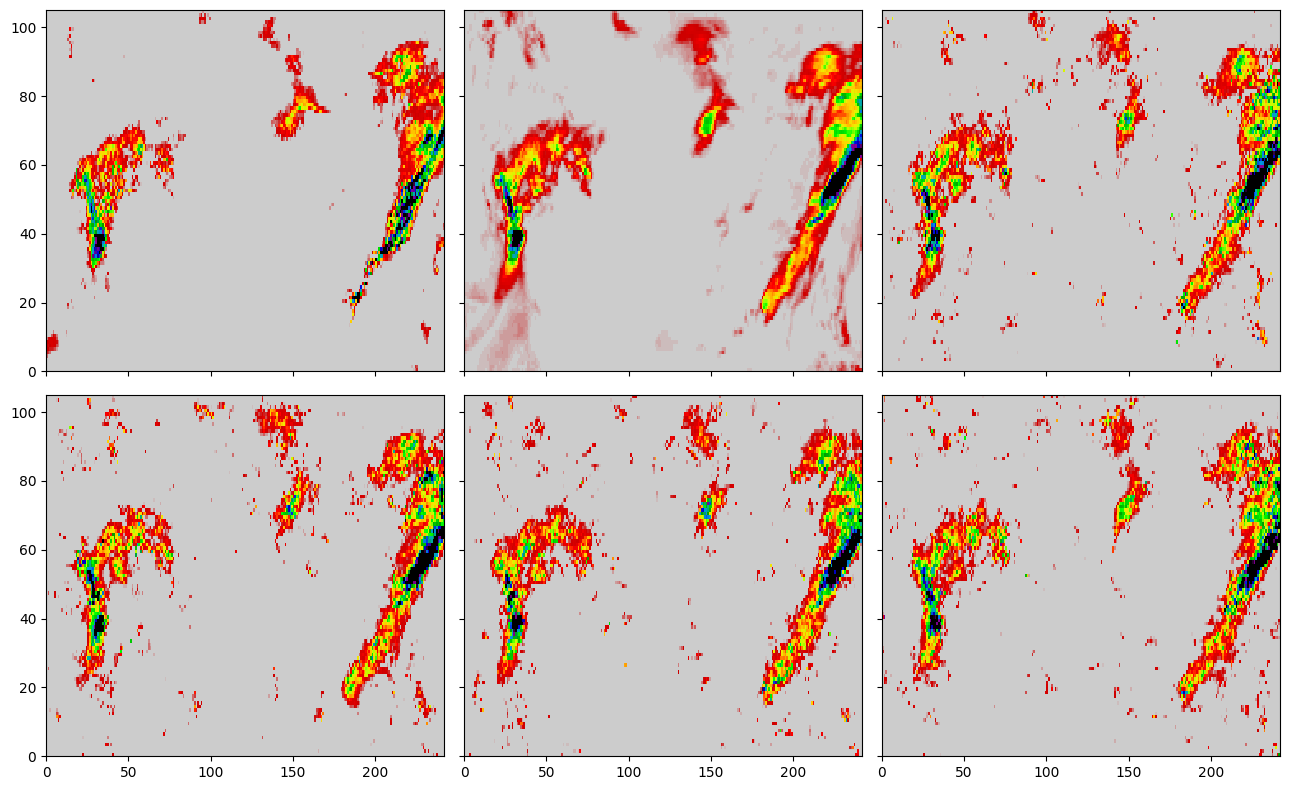

In [22]:
i_pick = 4

fig, AX = plt.subplots(2, 3, figsize=(13, 8), sharex=True, sharey=True)

AX[0][0].pcolormesh(MRMS_true_eval[0, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[0][1].pcolormesh(APCP_true_eval[0, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)

AX[0][2].pcolormesh(MRMS_pred_eval[0, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][0].pcolormesh(MRMS_pred_eval[1, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][1].pcolormesh(MRMS_pred_eval[2, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][2].pcolormesh(MRMS_pred_eval[3, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)

plt.tight_layout()

## Verification test

**CRPS**

In [23]:
y_pred = MRMS_pred_eval.reshape(10, 105*242)[None, ...]
y_true = MRMS_true_eval.reshape(105*242)[None, ...]

In [24]:
def CRPS_1d_nan(y_true, y_ens):
    '''
    Given one-dimensional ensemble forecast, compute its CRPS and corresponded two-term decomposition.
    np.nan will not propagate.
    
    CRPS, MAE, pairwise_abs_diff = CRPS_1d(y_true, y_ens)
    
    Grimit, E.P., Gneiting, T., Berrocal, V.J. and Johnson, N.A., 2006. The continuous ranked probability score 
    for circular variables and its application to mesoscale forecast ensemble verification. Quarterly Journal of 
    the Royal Meteorological Society, 132(621C), pp.2925-2942.
    
    Input
    ----------
        y_true: a numpy array with shape=(time, grids) and represents the (observed) truth 
        y_pred: a numpy array with shape=(time, ensemble_members, grids), represents the ensemble forecast
    
    Output
    ----------
        CRPS: the continuous ranked probability score, shape=(time, grids)
        MAE: mean absolute error
        SPREAD: pairwise absolute difference among ensemble members (not the spread)
        
    '''
    N_day, EN, N_grids = y_ens.shape
    M = 2*EN*EN
    
    # allocate outputs
    MAE = np.empty((N_day, N_grids),); MAE[...] = np.nan
    SPREAD = np.empty((N_day, N_grids),); SPREAD[...] = np.nan
    
    # loop over grid points
    for n in range(N_grids):
        # loop over days
        for day in range(N_day):
            # if obs is nan, then mark result as nan
            if np.isnan(y_true[day, n]):
                MAE[day, n] = np.nan
                SPREAD[day, n] = np.nan
            else:
                # calc MAE
                MAE[day, n] = np.mean(np.abs(y_true[day, n]-y_ens[day, :, n]))
                # calc SPREAD
                spread_temp = 0
                for en1 in range(EN):
                    for en2 in range(EN):
                        spread_temp += np.abs(y_ens[day, en1, n]-y_ens[day, en2, n])
                SPREAD[day, n] = spread_temp/M
            
    CRPS = MAE-SPREAD
    
    return CRPS, MAE, SPREAD


In [25]:
crps_, _, _ = CRPS_1d_nan(y_true, y_pred)

In [26]:
np.nanmean(crps_)

0.3142674326953012

**Reliability diagram test**

In [35]:
from sklearn.calibration import calibration_curve

In [36]:
Y_prob = MRMS_pred_domain > 10
Y_prob = np.mean(Y_prob, axis=0)
Y_true = MRMS_true_domain > 10

prob_true, prob_pred = calibration_curve(Y_true.ravel(), Y_prob.ravel(), n_bins=20)

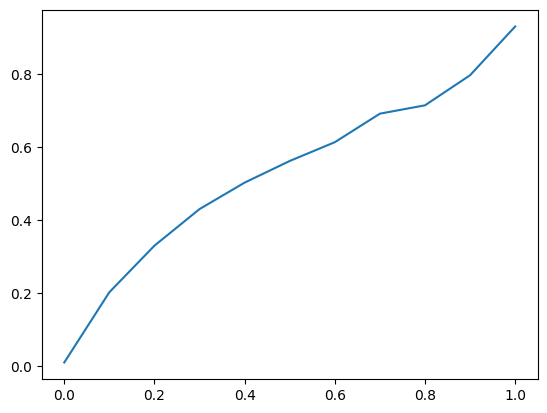

In [37]:
plt.plot(prob_pred, prob_true)

**Examples**